# Atividade 2
# Monte Carlo - Algoritmo de Metropolis - Ising

### Thaís Ferreira da Silva - 2021092571

### Bibliotecas

In [147]:
# Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numba import jit

### Funções do Roteiro
Código fornecido no enunciado para resolução do problema

In [148]:
#vizinhos = construção da tabela

@jit(nopython=True)
def vizinhos(N):
    #Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0): viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L: viz[k,3] = k+N-L
    return viz

In [149]:
# energia = calcular a enrgia de acordo com spin atual

@jit(nopython=True)
def energia(s,viz):
    #Calcula a energia da configuração representada no array s
    N=len(s)
    ener = 0
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]] # soma do valor dos spins a direita e acima
        ener -= s[i]*h
    return ener

In [150]:
#expos = calcular os 4 possiveis resultados da boltzmann

@jit(nopython=True)
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

### Funções Auxiliares Parte 1

In [151]:
@jit(nopython=True)
def algoritmo_de_metropolis(comprimento, temperatura, passos):
    # passos
    vetor_energia = np.zeros(passos)
    vetor_magnetizacao = np.zeros(passos)

    # vizinhos
    num_elementos = comprimento * comprimento
    vetor_vizinhos = vizinhos(num_elementos)

    # spin
    spin = np.random.choice(np.array([-1, 1]), num_elementos)

    # expos
    expoentes = expos(1/temperatura)

    # loop
    for p in range(passos):
        for n in range(num_elementos):
            soma = np.sum(spin[vetor_vizinhos[n]])
            indice = int(soma * 0.5 * spin[n] + 2)

            if np.random.rand() < expoentes[indice]:
                spin[n] = -1 * spin[n]

        vetor_energia[p] = energia(spin, vetor_vizinhos)
        vetor_magnetizacao[p] = np.sum(spin)

    return vetor_energia, vetor_magnetizacao


### Funções Auxiliares Parte 2

O calor específico é definido como:

$
c_v = \frac{\beta^2}{N} \left( \langle E^2 \rangle - \langle E \rangle^2 \right)
$


In [152]:
@jit(nopython=True)
def calor_especifico(temperatura, num_elementos, energia):
    beta = 1 / temperatura
    mean_E = np.mean(energia)
    mean_E2 = np.mean(energia ** 2)
    c_v = (beta ** 2 / num_elementos) * (mean_E2 - mean_E ** 2)
    return c_v

E a susceptibilidade magnética é dada por:

$
\chi = \frac{\beta}{N} \left( \langle M^2 \rangle - \langle M \rangle^2 \right)
$


In [153]:
@jit(nopython=True)
def susceptibilidade(temperatura, num_elementos, magnetizacao):
    beta = 1 / temperatura
    mean_M = np.mean(magnetizacao)
    mean_M2 = np.mean(magnetizacao ** 2)
    chi = (beta / num_elementos) * (mean_M2 - mean_M ** 2)
    return chi

In [154]:
@jit(nopython=True)
def erro_estatistico(estimativas):
    n = len(estimativas)
    media = np.mean(estimativas)
    variancia_amostral = np.sum((estimativas - media) ** 2) / n
    erro = np.sqrt(variancia_amostral / (n - 1))
    return erro


In [155]:
def remover_passos_de_termalizacao(dados, passos_termalizar):
    return np.array([dado[passos_termalizar:] for dado in dados])

In [156]:
def calcular_metricas_bloco(energias, magnetizacoes, temperatura, num_elementos, spins_por_segmento):
    num_blocos = len(energias) // spins_por_segmento
    metricas = np.zeros((num_blocos, 4))  # calor, susceptibilidade, energia, magnetização
    
    for i in range(num_blocos):
        bloco_energias = energias[i * spins_por_segmento: (i + 1) * spins_por_segmento]
        bloco_magnetizacoes = magnetizacoes[i * spins_por_segmento: (i + 1) * spins_por_segmento]

        calor = calor_especifico(temperatura, num_elementos, bloco_energias)
        susceptib = susceptibilidade(temperatura, num_elementos, bloco_magnetizacoes)
        energia_media = np.mean(bloco_energias) / num_elementos
        magnetizacao_media = np.mean(bloco_magnetizacoes) / num_elementos

        metricas[i] = [susceptib, calor, energia_media, magnetizacao_media]
    
    return metricas


In [157]:
def calcular_metricas_por_amostra(energias, magnetizacoes, temperatura, num_elementos, spins_por_segmento):
    metricas_amostra = [
        calcular_metricas_bloco(energias[i], magnetizacoes[i], temperatura, num_elementos, spins_por_segmento)
        for i in range(len(energias))
    ]
    return np.array(metricas_amostra)

In [158]:
def calcular_erros(metricas_por_bloco):
    erros = np.array([
        np.mean([erro_estatistico(metricas[:, i]) for metricas in metricas_por_bloco], axis=0)
        for i in range(4)
    ])
    return erros

def calcular_metricas_e_erros(energias, magnetizacoes, temperatura, num_elementos, spins_por_segmento):
    metricas_por_bloco = calcular_metricas_por_amostra(energias, magnetizacoes, temperatura, num_elementos, spins_por_segmento)
    erros = calcular_erros(metricas_por_bloco)
    return metricas_por_bloco, erros

In [159]:
# Main simulation functions
def salvar_metricas_bloco(energias, magnetizacoes, spins_por_segmento, passos_termalizar, temperatura, comprimento):
    num_elementos = comprimento * comprimento
    energias_atualizado = remover_passos_de_termalizacao(energias, passos_termalizar)
    magnetizacoes_atualizado = remover_passos_de_termalizacao(np.abs(magnetizacoes), passos_termalizar)
    
    metricas_por_bloco, erros = calcular_metricas_e_erros(
        energias_atualizado, magnetizacoes_atualizado, temperatura, num_elementos, spins_por_segmento
    )
    
    return metricas_por_bloco, erros

In [160]:
def plotar_metricas(temperaturas, resultado_metricas, erros, comprimento):
    nomes_metricas = ["Suscetibilidade", "Calor Específico", "Energia", "Magnetização"]
    
    # Criação da figura e da grade 2x2
    fig = plt.figure(figsize=(12, 8))  # Ajuste o tamanho da figura para acomodar 2x2 plots + gráfico de erros
    gs = gridspec.GridSpec(3, 2, figure=fig)  # 3 linhas e 2 colunas (adiciona mais uma linha)
    
    # Adiciona o título geral antes de plotar os gráficos
    fig.suptitle(f"L = {comprimento}", fontsize=16)  # Título geral, global para a figura inteira
    
    # Plotagem das métricas em cada subgráfico
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2])  # Distribui os gráficos nas posições (0, 0), (0, 1), (1, 0), (1, 1)
        ax.plot(temperaturas, resultado_metricas[:, :, i].mean(axis=1), 'o-', label=nomes_metricas[i])
        ax.fill_between(
            temperaturas,
            resultado_metricas[:, :, i].mean(axis=1) - erros[:, i],
            resultado_metricas[:, :, i].mean(axis=1) + erros[:, i],
            alpha=0.2,
        )
        ax.set_title(f"{nomes_metricas[i]}")  # Título individual para cada subplot
        ax.set_xlabel("Temperatura")
        ax.set_ylabel(nomes_metricas[i])
        ax.grid(True)
    
    # Plotando a variação dos erros
    ax_erros = fig.add_subplot(gs[2, :])  # A última linha ocupa toda a largura
    ax_erros.plot(temperaturas, erros.mean(axis=1), 'o-', color='red', label="Erro médio")
    ax_erros.set_title("Variação dos Erros Médios")
    ax_erros.set_xlabel("Temperatura")
    ax_erros.set_ylabel("Erro Médio")
    ax_erros.grid(True)
    ax_erros.legend()

    # Ajustando o espaçamento entre os subgráficos
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # Usando tight_layout para ajustar automaticamente e evitar sobreposição
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout para garantir que o título global não sobreponha
    plt.show()


def plotar_por_valores_temperatura(comprimento, amostras, temperaturas, passos_monte_carlo, spins_por_segmento, passos_termalizar):
    energias = np.zeros((amostras, passos_monte_carlo))
    magnetizacoes = np.zeros((amostras, passos_monte_carlo))
    
    resultado_metricas = np.zeros((len(temperaturas), amostras, 4))
    erros = np.zeros((len(temperaturas), 4))
    
    for idx, temperatura in enumerate(temperaturas):
        for j in range(amostras):
            energias[j], magnetizacoes[j] = algoritmo_de_metropolis(comprimento, temperatura, passos_monte_carlo)
        
        metricas_por_bloco, erros_temp = salvar_metricas_bloco(
            energias, magnetizacoes, spins_por_segmento, passos_termalizar, temperatura, comprimento
        )
        
        resultado_metricas[idx] = metricas_por_bloco.mean(axis=1)
        erros[idx] = erros_temp
    
    plotar_metricas(temperaturas, resultado_metricas, erros, comprimento)

In [161]:
# plotar graficos de energia e magnetização
def plotar_termalizacao(num_elementos, comprimento, temperatura, passos, energias, magnetizacoes):
    plt.figure(figsize=(12, 4))  # Ajusta o tamanho para acomodar os gráficos lado a lado

    # Título geral com os parâmetros
    plt.suptitle(f'N = {num_elementos}, L = {comprimento}, T = {temperatura}, passos = {passos}')

    # Subplot para Energia (primeiro gráfico)
    plt.subplot(1, 2, 1)
    for e in energias:
        plt.plot(e)
    plt.title('Energia')
    plt.ylabel('Energia')
    plt.xlabel('Passos')

    # Subplot para Magnetização (segundo gráfico)
    plt.subplot(1, 2, 2)
    for m in magnetizacoes:
        plt.plot(m)
    plt.title('Magnetização')
    plt.ylabel('Magnetização')
    plt.xlabel('Passos')

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserva espaço para o título
    plt.show()


### Parte 1- Simulação do modelo de Ising 2D

Para essa parte da simulação, analisamos as variações de temperatura e energia com os valores recomendados


In [162]:
#simulação
def simulacao(num_elementos, comprimento, temperatura, passos):

    energias = np.zeros((num_elementos, passos))
    magnetizacoes = np.zeros((num_elementos, passos))

    for i in range(num_elementos):
        energias[i], magnetizacoes[i] = algoritmo_de_metropolis(comprimento, temperatura, passos)

    plotar_termalizacao(num_elementos, comprimento, temperatura, passos, energias, magnetizacoes)

#### 1. Exemplo da atividade

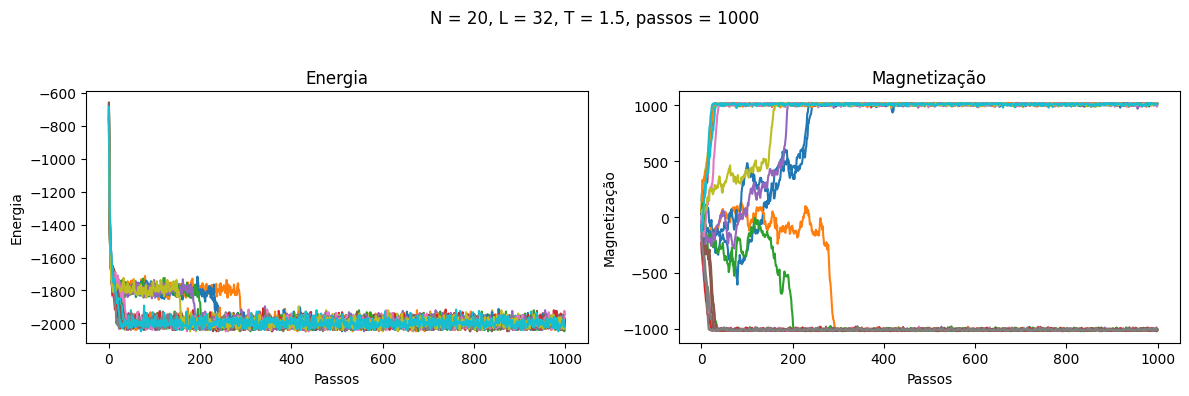

In [163]:
num_elementos = 20
comprimento = 32
temperatura = 1.5
passos = 1000
simulacao(num_elementos, comprimento, temperatura, passos)

#### 2. Vamos alterar o comprimento
Testes realizados com comprimentos: 20, 40, 60, 80, 100

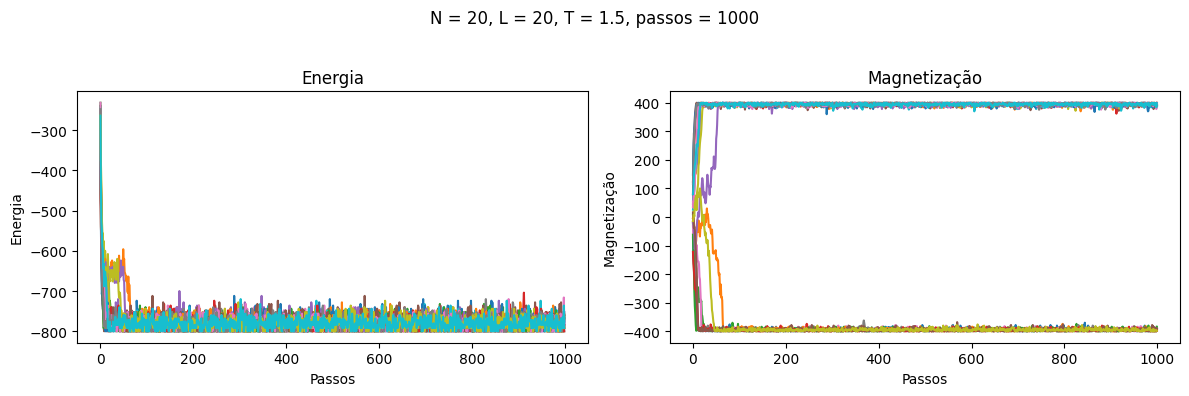

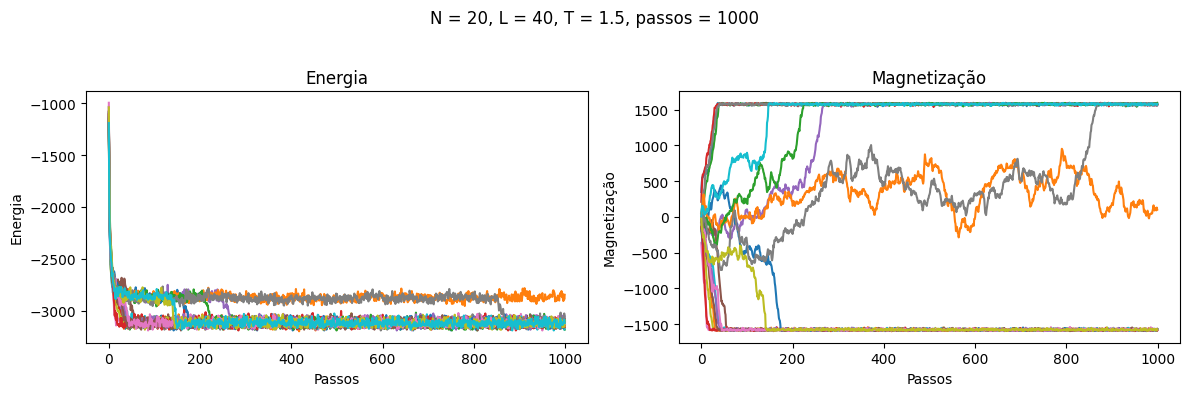

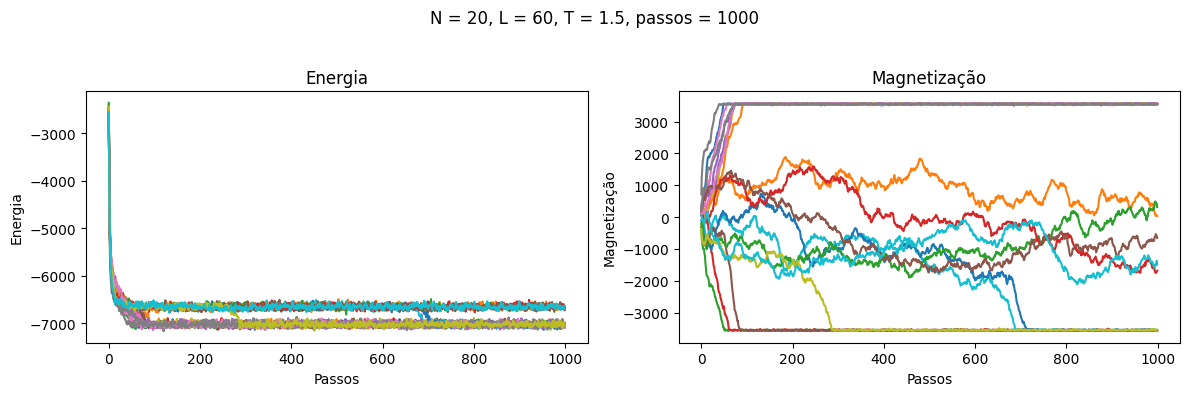

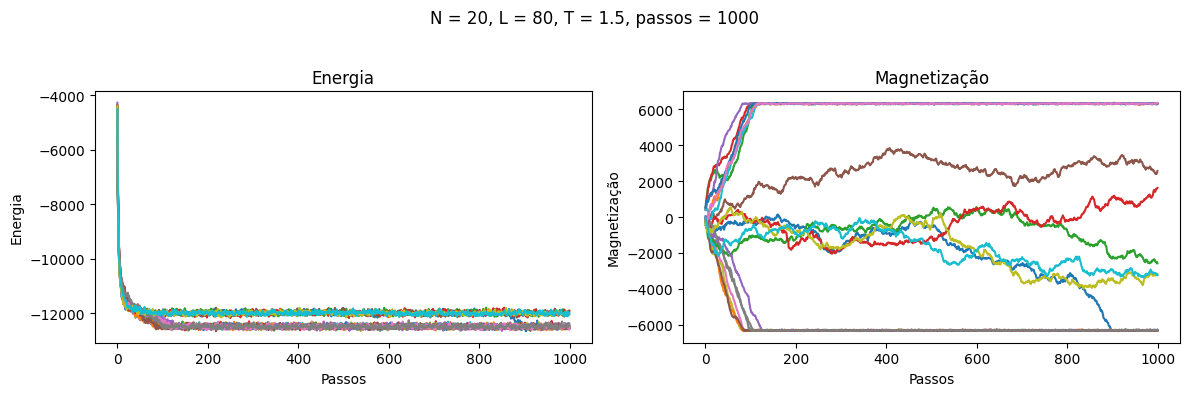

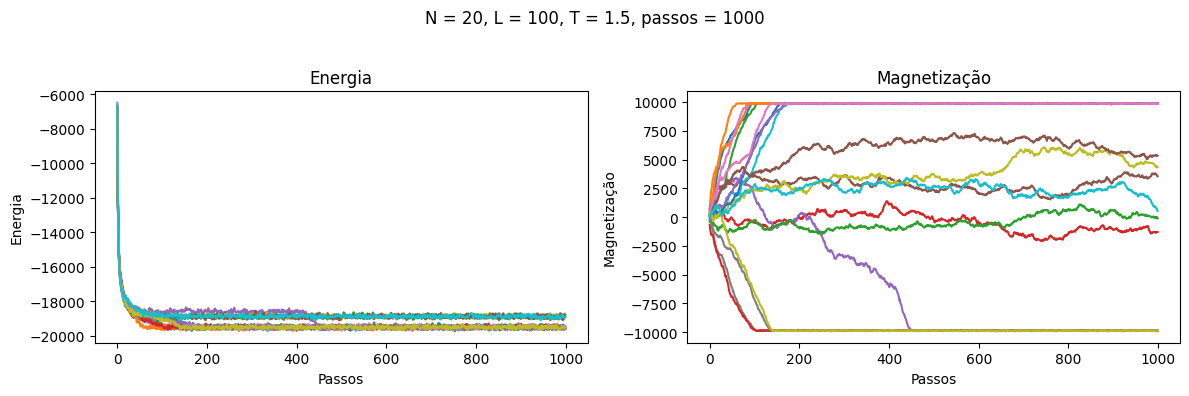

In [164]:
simulacao(20, 20, 1.5, 1000)
simulacao(20, 40, 1.5, 1000)
simulacao(20, 60, 1.5, 1000)
simulacao(20, 80, 1.5, 1000)
simulacao(20, 100, 1.5, 1000)

#### 3. Vamos alterar a temperatura
Testes realizados com temperaturas: 0.4, 1, 1.5, 2, 2.5, 3

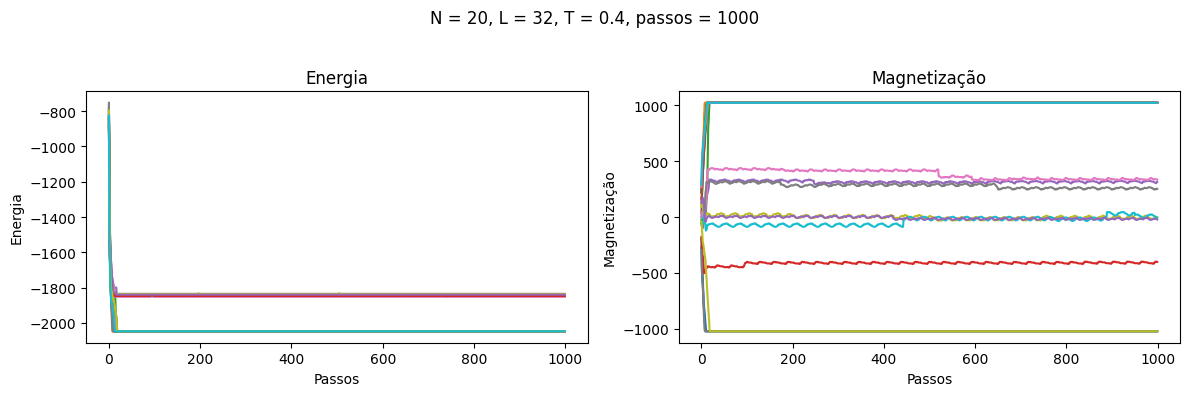

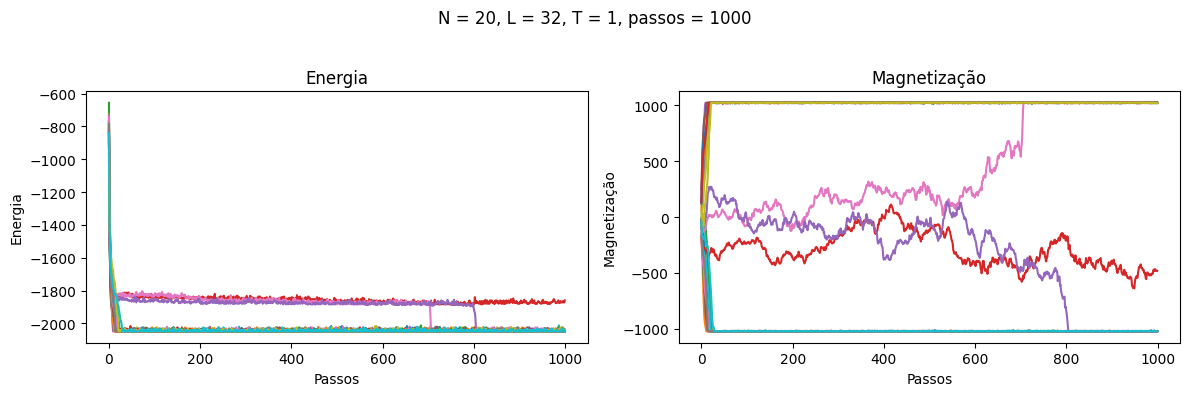

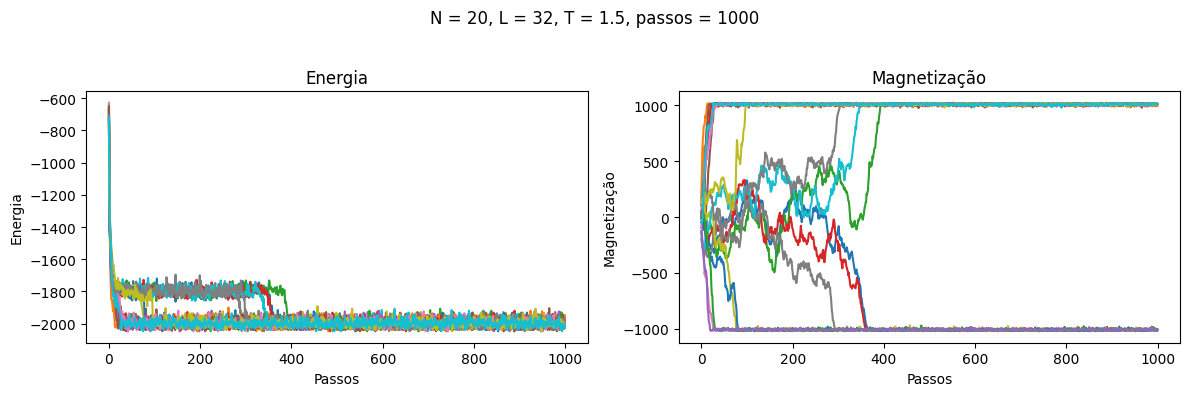

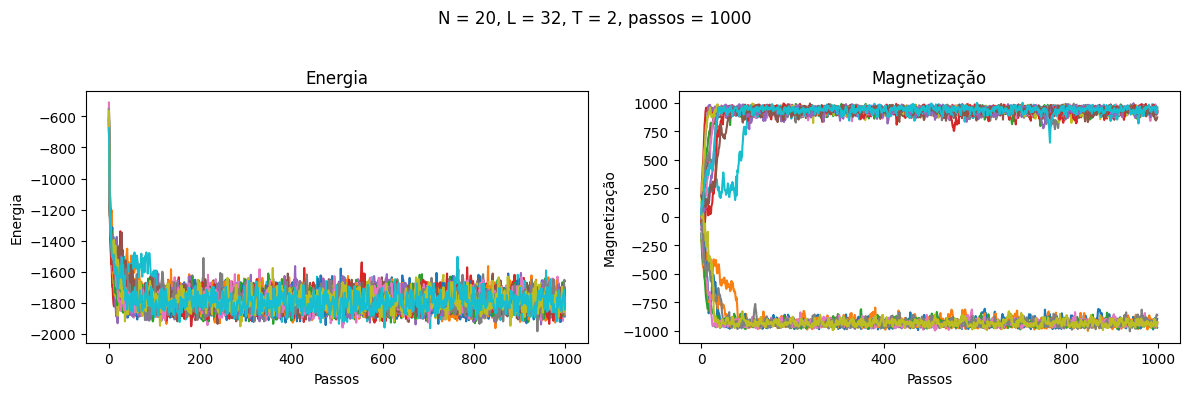

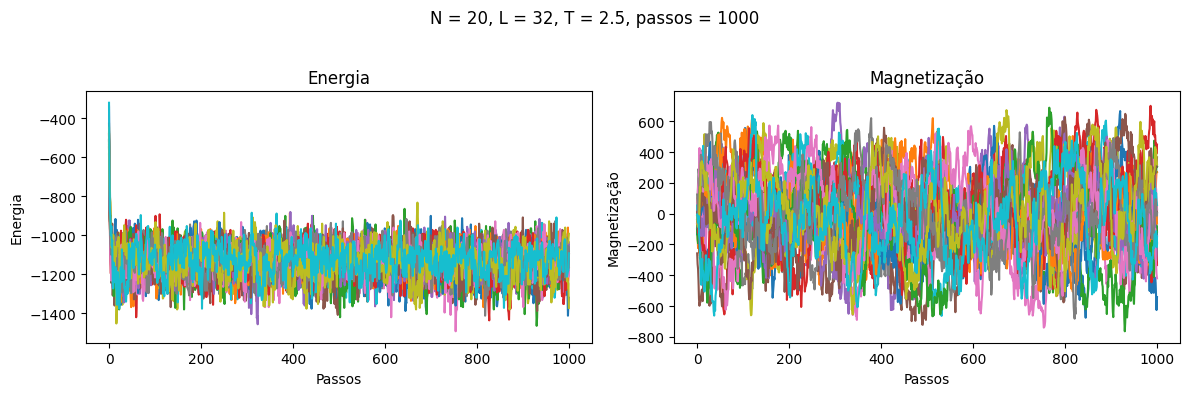

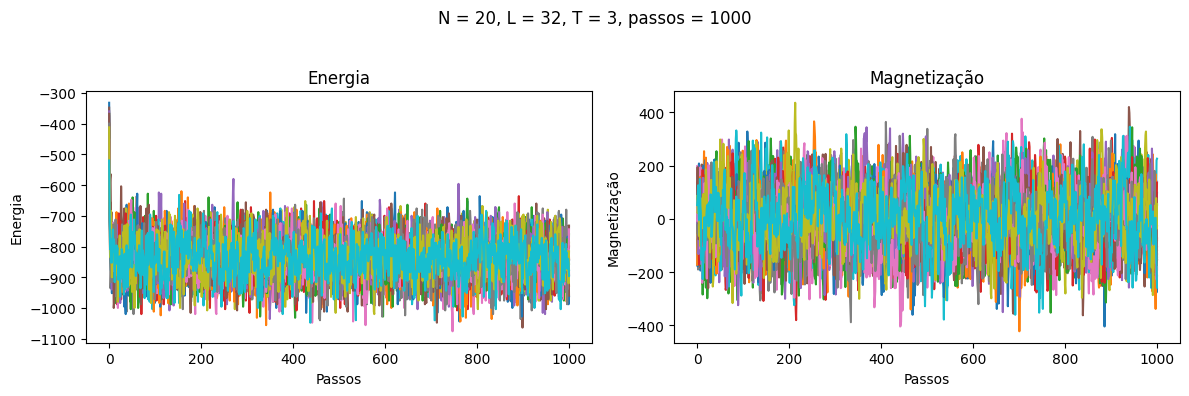

In [165]:
simulacao(20, 32, 0.4, 1000)
simulacao(20, 32, 1, 1000)
simulacao(20, 32, 1.5, 1000)
simulacao(20, 32, 2, 1000)
simulacao(20, 32, 2.5, 1000)
simulacao(20, 32, 3, 1000)

#### Análise Parte 1
Aqui está a análise reescrita em forma de texto contínuo:

Com base nos experimentos realizados, foi possível observar que a temperatura desempenha um papel crucial na convergência da energia. O aumento da temperatura torna o processo de convergência significativamente mais lento, e, em temperaturas muito altas, a energia pode não estabilizar. Por outro lado, em temperaturas mais baixas, há uma tendência de a energia convergir para valores menores, indicando maior estabilidade do sistema. Entretanto, mesmo com temperaturas reduzidas, algumas instâncias não convergiram, apresentando padrões repetitivos. 

Em relação ao comprimento da rede, os resultados sugerem que sua influência é menor em comparação com a temperatura. Quando o comprimento da rede aumenta, a energia total do sistema diminui, o que pode fazer com que as variações entre picos e vales se tornem menos pronunciadas conforme o sistema se aproxima da convergência. No entanto, com base nos dados analisados, não foi possível afirmar com segurança que redes maiores dificultam a convergência.

### Parte 2 - Simulação do Modelo de Ising 2D
Utilizando como base:
Vocês devem, então, verificar de forma qualitativa como o número de passos de termalização varia  de acordo com o tamanho do sistema e com a temperatura da simulação. Sugiro tamanhos de rede  entre 24 e 100 e temperaturas entre 0.4 e 3, mas sintam-se livres para explorar mais tamanhos ou  temperaturas. 

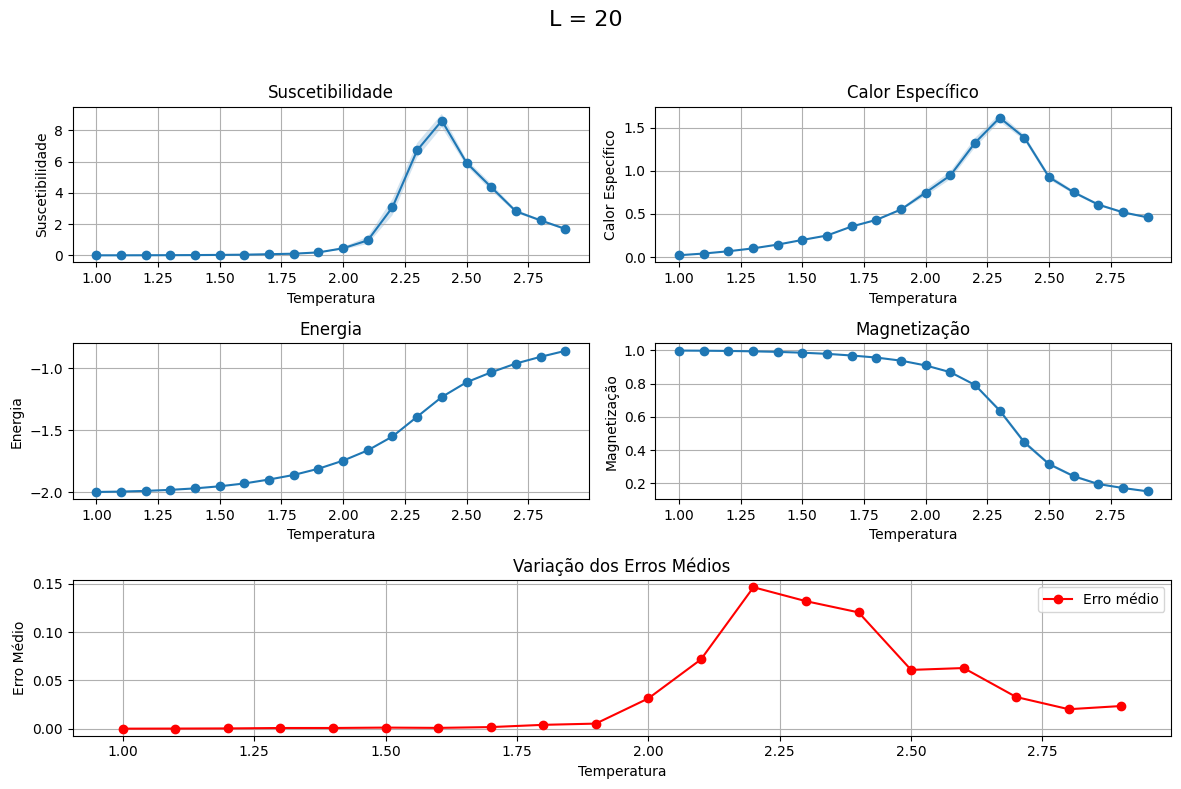

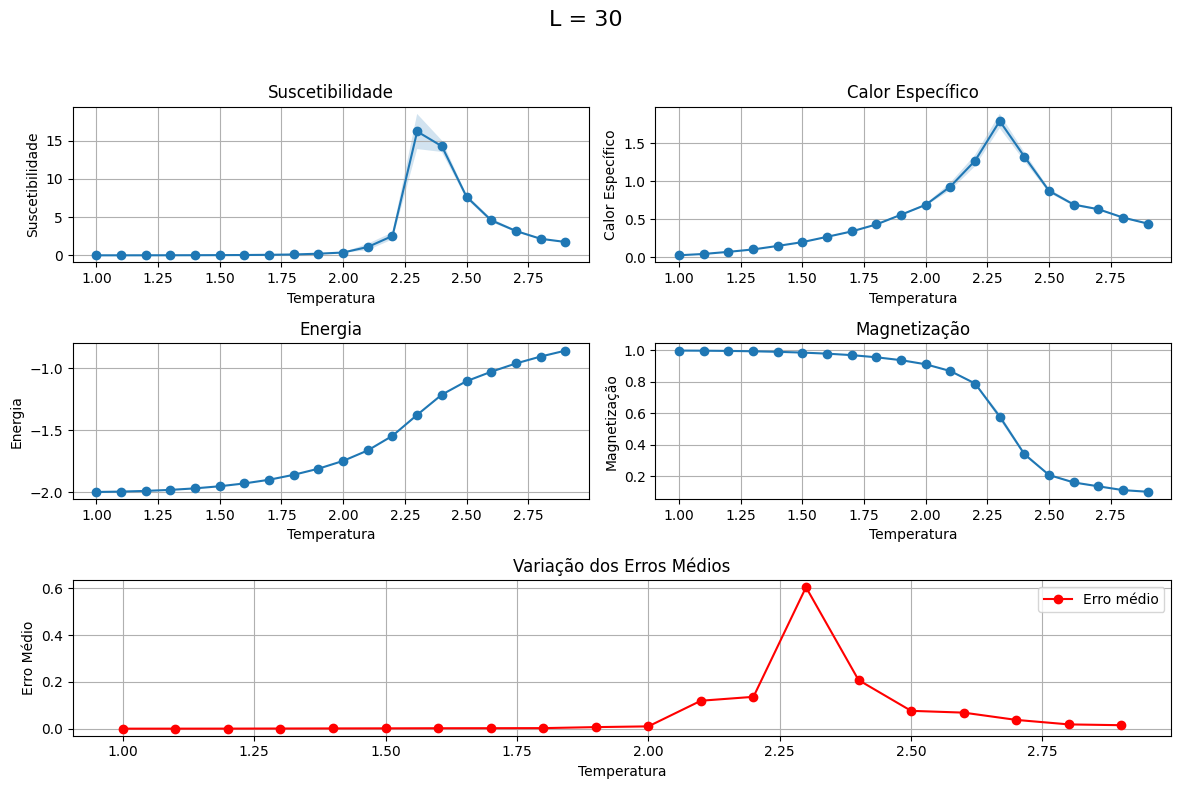

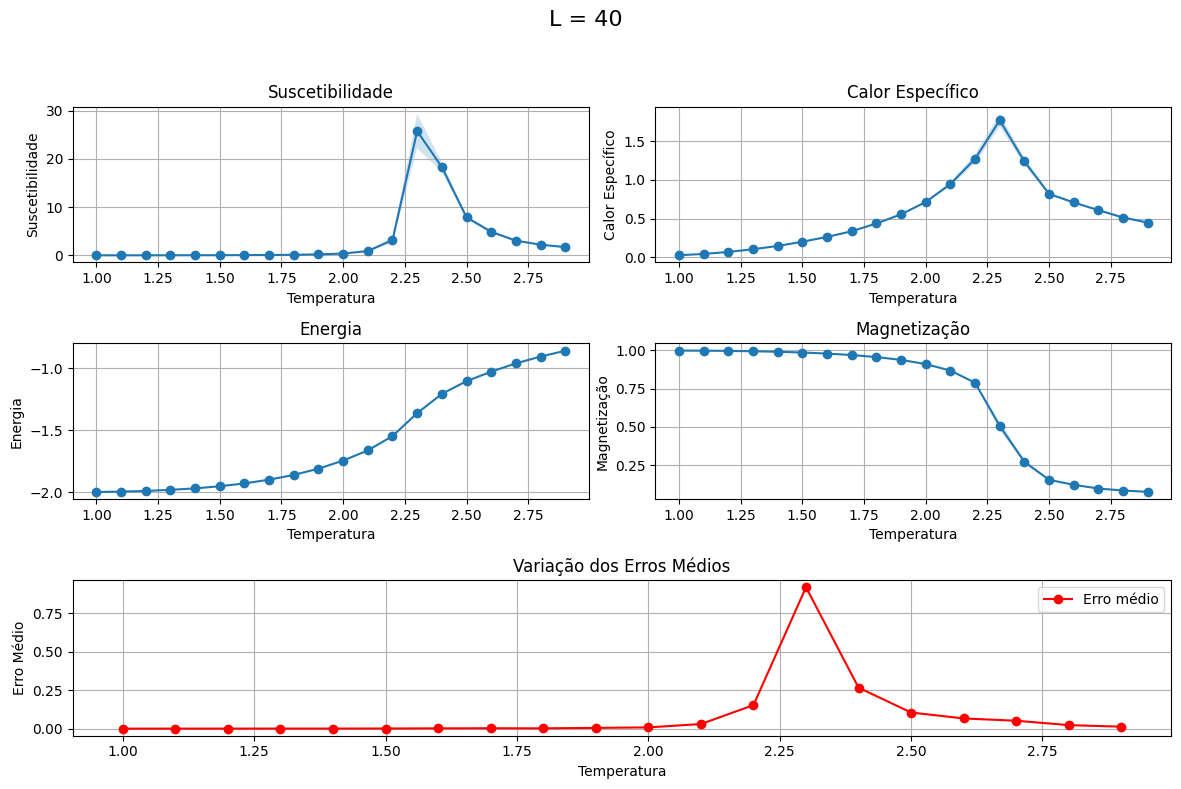

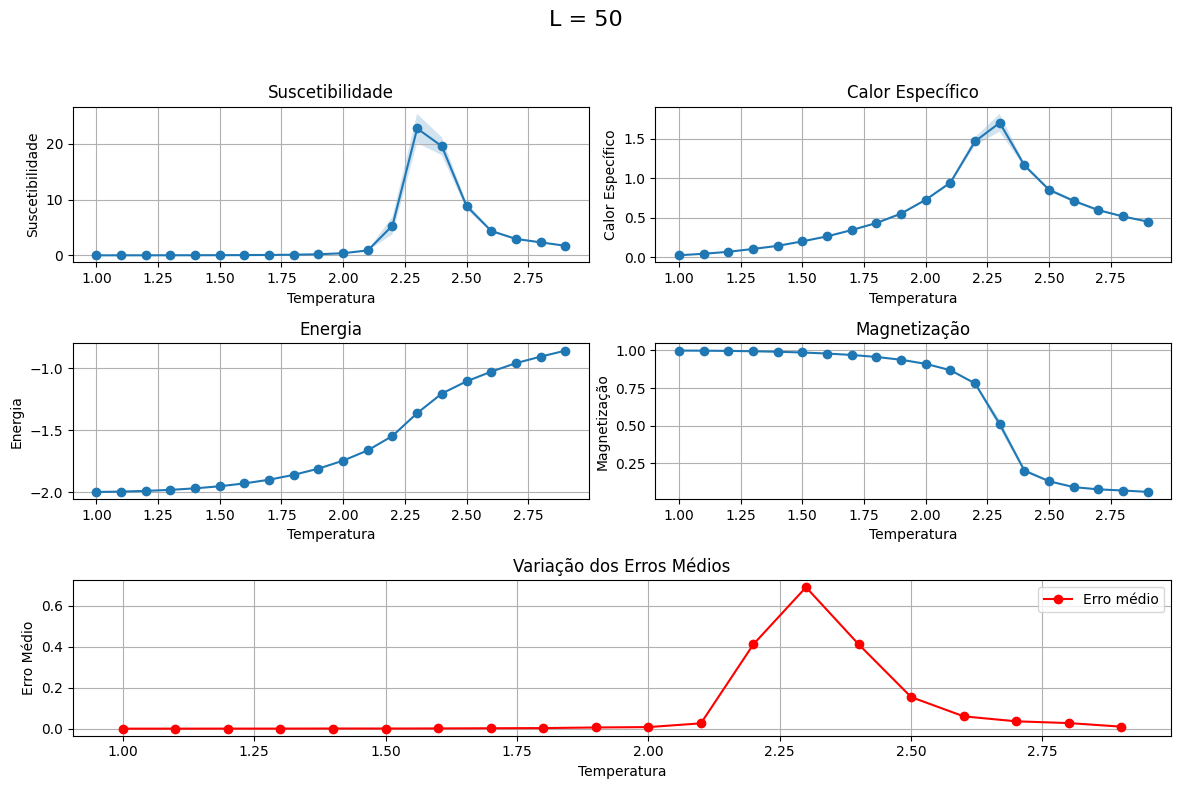

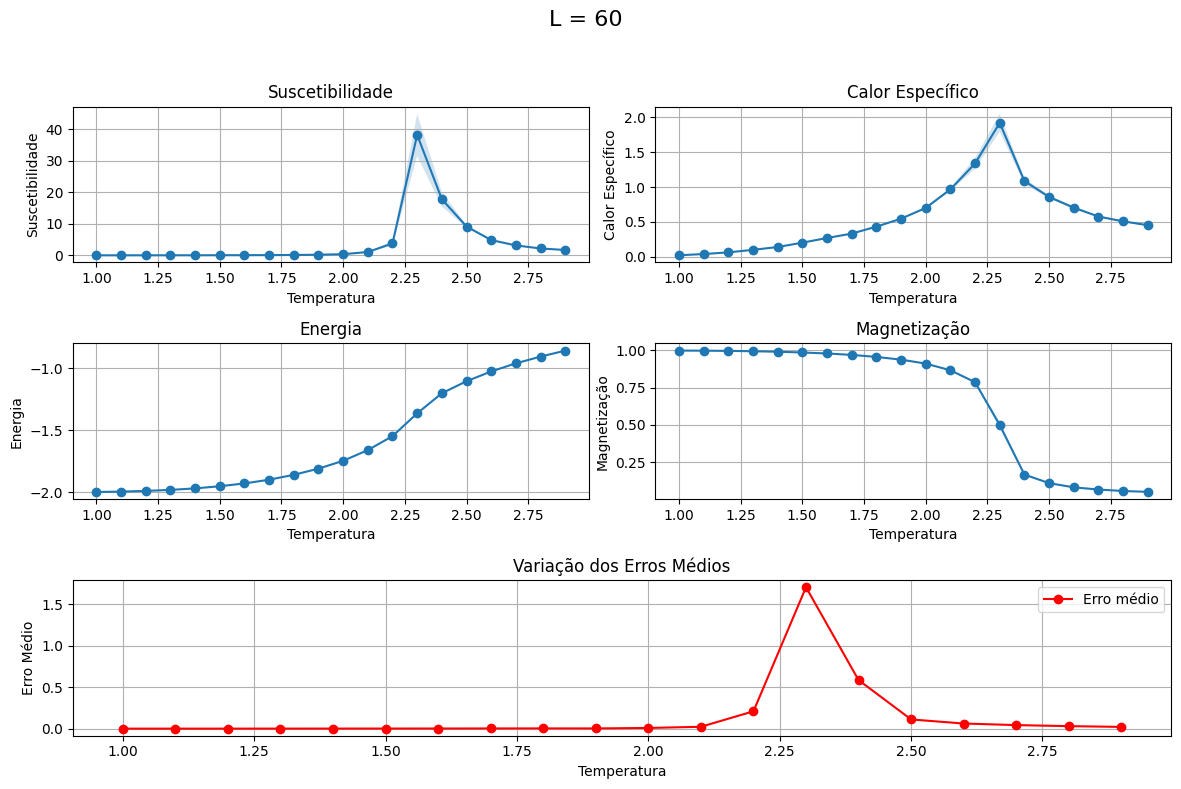

In [167]:
# Número de amostras a ser utilizado na simulação
amostras = 1

# Lista de diferentes comprimentos (L) que serão analisados
comprimentos = np.array([20, 30, 40, 50, 60])

# Número de passos para "termalizar"
passos_termalizacao = 5500

# Quantidade de spins por bloco, usado na função de cálculo das métricas
spins_por_segmento = 600

# Temperaturas para a simulação
temperaturas = np.arange(1, 3, 0.1)

# Número total de passos para a simulação de Monte Carlo
passos_monte_carlo = 13000

# Loop que percorre os diferentes valores de comprimento (L) para gerar os gráficos
for comprimento in comprimentos:
    plotar_por_valores_temperatura(comprimento, amostras, temperaturas, passos_monte_carlo,spins_por_segmento, passos_termalizacao )

#### Análise Parte 2
1) Quais  critérios  você  utilizou  para  escolher  os  valores  dos  parâmetros  descritos  acima?  Provavelmente suas escolhas iniciais precisarão ser revistas, não há problemas! Pelo  contrário, o ideal é que ao longo do trabalho você vá revendo suas escolhas, aprimorando-as,  mas quero saber quais os principais fatores que nortearam suas escolhas finais.  

Inicialmente, eu utilizei os parâmetros fornecidos na própria atividade e, a partir daí, fui ajustando os valores. Para ajustar esses valores, optei pela experimentação, rodando várias vezes e analisando o impacto de cada decisão. No entanto, segui uma ordem:

- Comprimento: comecei com os mesmos valores da parte 1, mas percebi que L acima de 60 gerava resultados insatisfatórios e demorava muito para rodar. Acabei ficando com as variações de 20 a 60.
- Passos de termalização: comecei com 1000 e parei no valor de 5500, por ser um dos valores mais estáveis testados. Spins por segmento: mesma lógica, comecei com um valor baixo de 100 e fui aumentando até 600.
- Temperatura: inicialmente, coloquei os valores como no exemplo da atividade, variando entre 0.4 e 3, mas percebi que os melhores resultados ocorreram a partir da temperatura 1.
- Passos de Monte Carlo: também comecei com um valor arbitrário e fui ajustando. Percebi que 1300 foi um dos melhores resultados ao variar o valor a partir de 10000.

_________________________________________________________________________________________________________________________________________________

2) Descreva o comportamento observado para as  principais grandezas termodinâmicas –  Energia por spin, Magnetização por spin, calor específico e susceptibilidade magnética – em  função da temperatura. Ou seja, ao variar a temperatura, o que acontece com o valor destas  grandezas? Quais são os limites para baixas e altas temperaturas? Há algum pico ou vale? O  comportamento está em acordo com o que você esperava? 

Ao aumentar a temperatura, percebi que o valor da energia aumenta, enquanto o da magnetização vai diminuindo. O que já era esperado, tendo em vista os resultados obtidos na parte 1. Esse comportamento é estável, não sendo modificado em simulações maiores.

Já o calor específico e a susceptibilidade magnética geram um pico ao alcançarem temperaturas por volta de 2 a 2.5, evidenciando o momento de troca de fase. Isso pode ser visto também pela queda dos valores de magnetização após esse pico.

_________________________________________________________________________________________________________________________________________________

3) Ao variar o tamanho do sistema, como as curvas destas grandezas em função da temperatura  se modifica? Há algum intervalo de temperaturas no qual as grandezas são independentes do  tamanho  do  sistema?  Em  regiões  onde  há  variação  com  o  tamanho  do  sistema,  como  a  grandeza é modificada quando 𝐿 aumenta? 

O comportamento para as 4 métricas é bem parecido, independentemente do valor de L. Inicialmente, temos um crescimento mais linear e controlado, e depois de alcançar a temperatura 2, há uma mudança no comportamento do sistema com grandes variações. Por fim, o sistema volta a se tornar linear e controlado novamente.
_________________________________________________________________________________________________________________________________________________

4) Como  é  o  comportamento  dos  erros  estatísticos  à  medida  que  a  temperatura  varia?  Tem  algum  valor  de  temperatura  em  torno  do  qual  os  erros  são  maiores?  Você  enxerga  algum  motivo para isso? Os erros estatísticos dependem do tamanho do sistema? Como? 

Como comentado anteriormente, os erros estatísticos de todas as grandezas possuem um valor maior entre as temperaturas 2 e 2.5, o que pode ser observado no gráfico vermelho plotado.

Ao analisarmos as grandezas separadamente, podemos perceber que a energia e a magnetização possuem picos maiores em sistemas maiores, a susceptibilidade possui picos maiores em sistemas menores, e o calor específico não é muito afetado pelo tamanho.

_________________________________________________________________________________________________________________________________________________

5) Com base no comportamento encontrado, identifique possíveis fases do sistema,  descrevendo as principais características das fases encontradas. 

Temos 3 fases no total, marcadas por mudanças bruscas no sistema:

- 1° Até 2 de temperatura: Onde temos um sistema mais estável. 
- 2° Entre 2 e 2.5 de temperatura: Marcada por uma brusca mudança nos valores, e um valor alto de erros. 
- 3° Após 2.5 de temperatura: Um retorno para a estabilidade.

_________________________________________________________________________________________________________________________________________________

6) Estime,  utilizando  os  dados  das  suas  simulações,  a  temperatura  de  transição  de  fase  do  sistema no limite termodinâmico, i.e., para o limite em que o tamanho do sistema é infinito.

Em simulações maiores, essa temperatura de transição ocorreu aproximadamente entre 2.2 e 2.5, então acredito que esse seja o comportamento para quando o tamanho do sistema é infinito.

_________________________________________________________________________________________________________________________________________________

OBS: Utilizei o ChatGPT para a geração dos gráficos com o intuito de gerenciar melhor o espaço dos plots.